# Dataset Analysis

Exploratory analysis of the unified dataset index (`datasets/unified_index.json`).

In [2]:
!pip install matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 73.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 55.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [seaborn]m5/6 [seaborn]ib]


In [6]:
import json
from pathlib import Path
from collections import Counter

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

DATA_ROOT = Path.cwd().resolve()
INDEX_REL = Path("datasets") / "unified_index.json"
if not (DATA_ROOT / INDEX_REL).exists():
    parent = DATA_ROOT.parent
    while parent != parent.parent:
        candidate = parent / INDEX_REL
        if candidate.exists():
            DATA_ROOT = parent
            break
        parent = parent.parent

INDEX_PATH = DATA_ROOT / INDEX_REL
if not INDEX_PATH.exists():
    raise FileNotFoundError(f"Unified index not found. Expected at {INDEX_PATH}")

with INDEX_PATH.open() as fp:
    index_payload = json.load(fp)

entries = index_payload["entries"]
df = pd.DataFrame(entries)
df.head()

,track_id,dataset,audio_path,midi_path,duration_seconds,audio_num_frames,audio_sample_rate,instrument_programs,instrument_names,instrument_classes,split,is_drum,num_rendered_stems,num_total_stems,rendered_stem_ids,stem_id
0,maestro-datasets_maestro-v3.0.0_2004_MIDI-Unpr...,maestro,datasets/maestro-v3.0.0/2004/MIDI-Unprocessed_...,datasets/maestro-v3.0.0/2004/MIDI-Unprocessed_...,968.256759,42760043,44100,[0],[Acoustic Grand Piano],[Piano],train,False,NaN,NaN,NaN,NaN
1,maestro-datasets_maestro-v3.0.0_2004_MIDI-Unpr...,maestro,datasets/maestro-v3.0.0/2004/MIDI-Unprocessed_...,datasets/maestro-v3.0.0/2004/MIDI-Unprocessed_...,267.438314,11794042,44100,[0],[Acoustic Grand Piano],[Piano],validation,False,NaN,NaN,NaN,NaN
2,maestro-datasets_maestro-v3.0.0_2004_MIDI-Unpr...,maestro,datasets/maestro-v3.0.0/2004/MIDI-Unprocessed_...,datasets/maestro-v3.0.0/2004/MIDI-Unprocessed_...,190.852001,8580363,44100,[0],[Acoustic Grand Piano],[Piano],test,False,NaN,NaN,NaN,NaN
3,maestro-datasets_maestro-v3.0.0_2004_MIDI-Unpr...,maestro,datasets/maestro-v3.0.0/2004/MIDI-Unprocessed_...,datasets/maestro-v3.0.0/2004/MIDI-Unprocessed_...,312.655061,13788120,44100,[0],[Acoustic Grand Piano],[Piano],test,False,NaN,NaN,NaN,NaN
4,maestro-datasets_maestro-v3.0.0_2004_MIDI-Unpr...,maestro,datasets/maestro-v3.0.0/2004/MIDI-Unprocessed_...,datasets/maestro-v3.0.0/2004/MIDI-Unprocessed_...,1409.288578,62196954,44100,[0],[Acoustic Grand Piano],[Piano],train,False,NaN,NaN,NaN,NaN


In [7]:
df["duration_minutes"] = df["duration_seconds"].fillna(0) / 60.0
summary = (
    df.groupby(["dataset", "split"])
    .agg(num_tracks=("track_id", "nunique"),
         total_hours=("duration_minutes", lambda x: x.sum() / 60))
    .reset_index()
)
summary

,dataset,split,num_tracks,total_hours
0,maestro,test,177,19.979978
1,maestro,train,962,159.243734
2,maestro,validation,137,19.429495
3,slakh_full_mix,test,151,10.985003
4,slakh_full_mix,train,1289,88.928327
5,slakh_full_mix,validation,270,18.346615
6,slakh_stem,test,1539,113.355358
7,slakh_stem,train,13546,948.189992
8,slakh_stem,validation,2833,195.072971


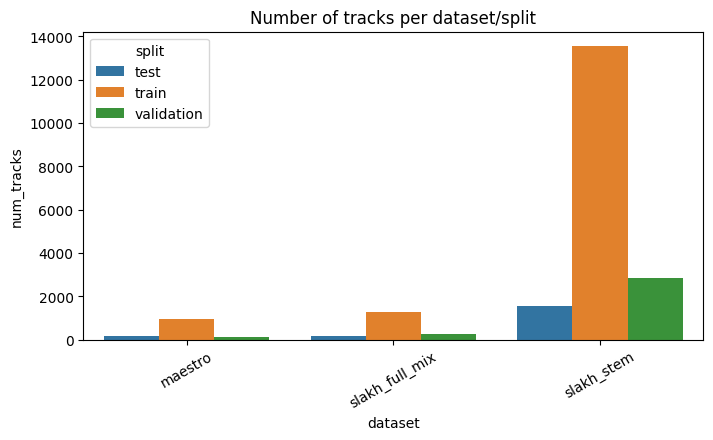

In [8]:
plt.figure(figsize=(8, 4))
sns.barplot(summary, x="dataset", y="num_tracks", hue="split")
plt.title("Number of tracks per dataset/split")
plt.xticks(rotation=30)
plt.show()

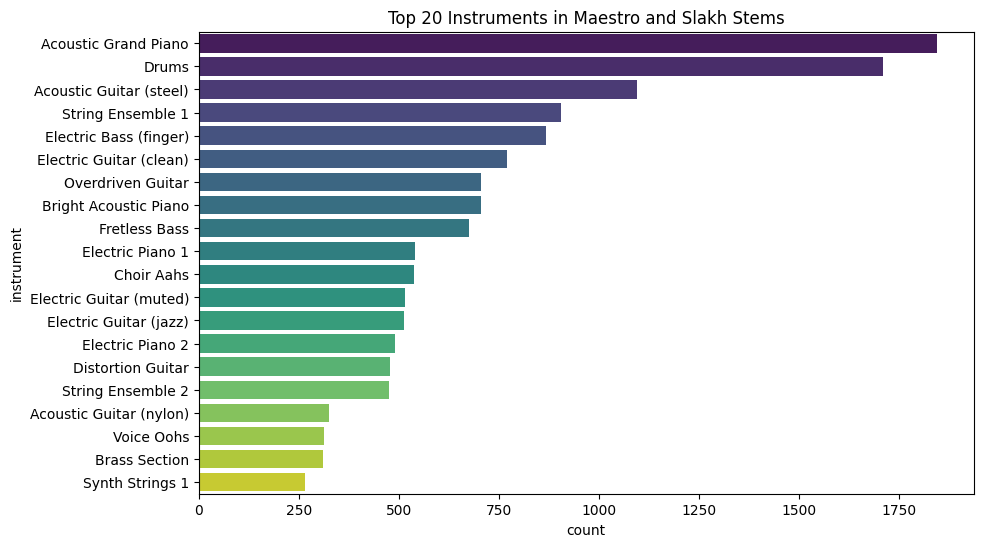

In [13]:
# counts the number of samples per instrument based on the instrument_names field for maestro and slakh_stems  
instrument_counts = Counter()
for entry in entries:
    if entry["dataset"] in ["maestro", "slakh_stem"]:
        instrument_names = entry.get("instrument_names", [])
        instrument_counts.update(instrument_names)
instrument_df = pd.DataFrame(instrument_counts.items(), columns=["instrument", "count"])
instrument_df = instrument_df.sort_values(by="count", ascending=False).head(20)
plt.figure(figsize=(10, 6))
sns.barplot(instrument_df, x="count", y="instrument", palette="viridis", hue="instrument", legend=False)
plt.title("Top 20 Instruments in Maestro and Slakh Stems")
plt.show()


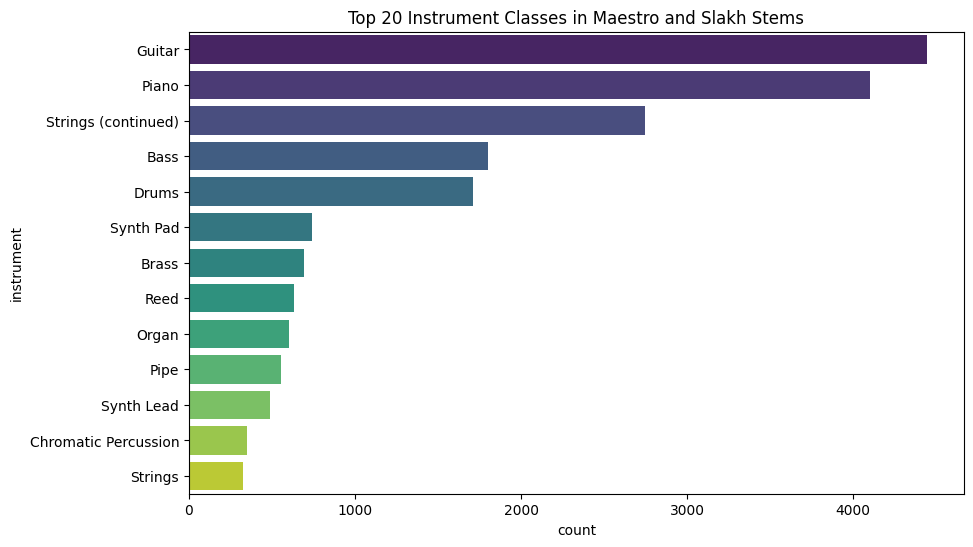

In [14]:
# counts the number of samples per instrument based on the instrument_classes field for maestro and slakh_stems  
instrument_counts = Counter()
for entry in entries:
    if entry["dataset"] in ["maestro", "slakh_stem"]:
        instrument_classes = entry.get("instrument_classes", [])
        instrument_counts.update(instrument_classes)
instrument_df = pd.DataFrame(instrument_counts.items(), columns=["instrument", "count"])
instrument_df = instrument_df.sort_values(by="count", ascending=False).head(20)
plt.figure(figsize=(10, 6))
sns.barplot(instrument_df, x="count", y="instrument", palette="viridis", hue="instrument", legend=False)
plt.title("Top 20 Instrument Classes in Maestro and Slakh Stems")
plt.show()